# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from  PIL import Image
import numpy as np

In [2]:
lst = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
lst.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
lst.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Объём датасета 7,5 тысячи изображений. Этого явно не достаточно для обучения глубокой нейросети, но для дообучения предварительно обученной CNN вполне достаточно. Если бы датасет был ещё меньше, пришлось бы обучать выкручиваться, обучая только выходной слой, заморозив саму предобученную сеть. 

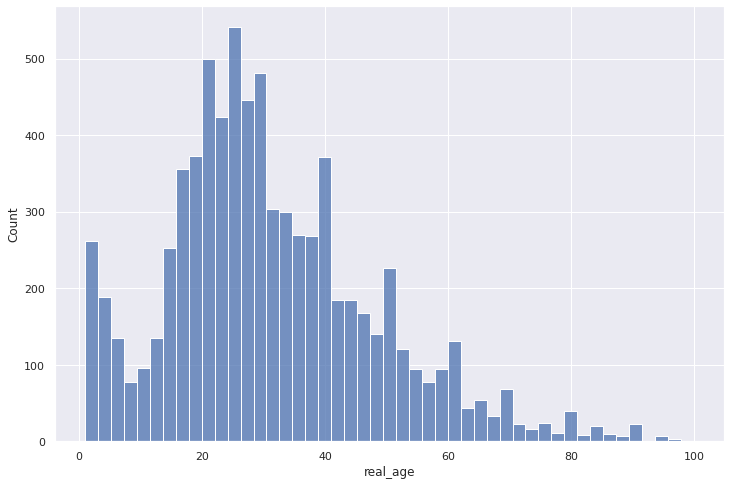

In [5]:
sns.set(rc={'figure.figsize':(12,8)})

sns.histplot(lst, x='real_age');

Видно, что распределение похоже на пуассоновское, которого следовало бы ожидать. Но есть нюансы: во-первых, большой выброс наблюдается возле нуля: на фото много маленьких детей. Это может быть связано с семейным характером магазина. Или маленьких детей в принципе часто фотографируют. Кроме того, имеются выбросы ("иглы") возле круглых значений возрастов: 40, 50, ... лет. Это может быть вызвано приблизительным указанием возраста (39,5 и 41 могли быть округлены до 40)   

In [6]:
path = '/datasets/faces/final_files/'

In [7]:
rows = 3
columns = 4

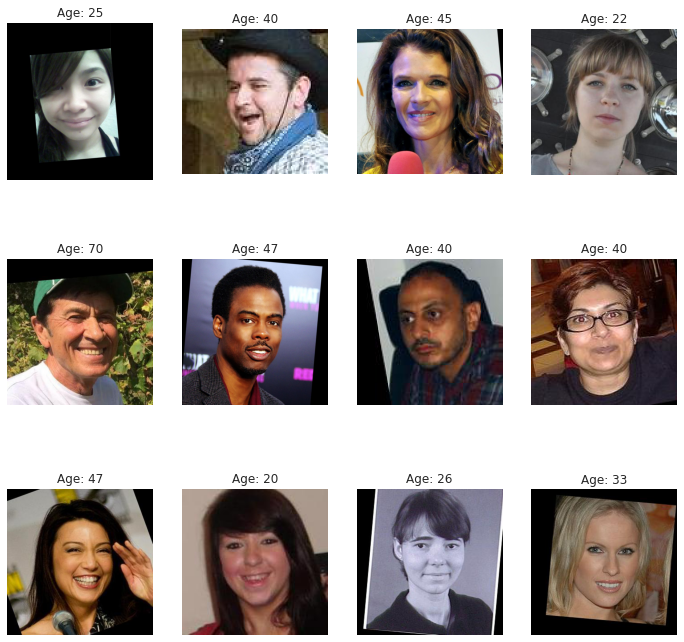

In [8]:
fig=plt.figure(figsize=(12, 12))
count = 1
for  _,file,age in lst.sample(12).itertuples():
    img = Image.open(path+file)
    fig.add_subplot(rows, columns, count)
    count+=1
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(f"Age: {age}");

## Вывод

Датасет похож на неочень упордоченный набор фото из разных эпох и источников: есть и явно старые чёрно-белые фото, профессиональные фото знаменитостей и посредственного качества семейные фото. Это, в том числе, объясняет большое количество изображений детей до 10 лет. 

Это может стать проблемой, так как вряд ли в числе покупателей магазино будет много столь юных покупателей. Иными словами, распределения по возрастам в обучающей и боевой выборках скорее всего не совпадут.

Разумно было бы избавиться от фото детей хотя бы до 10 лет

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.25)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + '/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw',
    subset='training',
    seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    val_datagen_flow = val_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + '/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw', 
    subset='validation',
    seed=42)
    return val_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    cnn = ResNet50(input_shape=input_shape, include_top=False,           
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
        )

    model = Sequential()
    model.add(cnn)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))
    model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=["mae"])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              verbose=2, shuffle=True)
    return model 
```

Epoch 1/10

89/89 - 67s - loss: 12.0640 - mae: 12.0642 - val_loss: 23.3699 - val_mae: 23.2732

Epoch 2/10

89/89 - 42s - loss: 7.0584 - mae: 7.0581 - val_loss: 25.1179 - val_mae: 25.0185

Epoch 3/10

89/89 - 44s - loss: 5.7803 - mae: 5.7806 - val_loss: 24.4334 - val_mae: 24.3386

Epoch 4/10

89/89 - 41s - loss: 5.2597 - mae: 5.2604 - val_loss: 22.6592 - val_mae: 22.5707

Epoch 5/10

89/89 - 46s - loss: 4.7348 - mae: 4.7349 - val_loss: 20.4530 - val_mae: 20.3559

Epoch 6/10

89/89 - 46s - loss: 4.2566 - mae: 4.2568 - val_loss: 15.2310 - val_mae: 15.1519

Epoch 7/10

89/89 - 46s - loss: 3.9790 - mae: 3.9791 - val_loss: 9.7077 - val_mae: 9.6736

Epoch 8/10

89/89 - 51s - loss: 3.7766 - mae: 3.7768 - val_loss: 7.9625 - val_mae: 7.9772

Epoch 9/10

89/89 - 50s - loss: 3.5682 - mae: 3.5684 - val_loss: 7.2344 - val_mae: 7.2308

Epoch 10/10

89/89 - 49s - loss: 3.4212 - mae: 3.4214 - val_loss: 6.3890 - val_mae: 6.3933

60/60 - 11s - loss: 6.3890 - mae: 6.3933

Test MAE: 6.3933

## Анализ обученной модели

Предобученная на наборе `Imagenet` нейросеть ResNet50 дообучается довольно быстро: хватило всего 10 эпох, чтобы MAE снизилась ниже 7. 

При обучении использовался единственный параметр аугментации - отражение по горизонтали. Использование вертикального и горизонтального сдвигов, а также вариации яркости не дали положительных результатов, а поворот работал слишком долго, что приводило к остановке по таймауту.

# Вывод

Использование предварительно обученных глубоких нейросетей даёт возможность быстро адаптировать под нужды новых задач и добиваться высокой точности распознавания (в широком смысле) за сравнительно короткое время с привлечением даже сравнительно ограниченных вычислительных ресурсов, например, арендованных вычислительных ресурсов в облачных сервисах.